In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import skvideo.io
from skimage import feature
from scipy import ndimage as sc
from PIL import Image as im
import pandas as pd

In [2]:
imagePath = "C:/Users/antonkout/Documents/Publications/paper/synchronized/new/code"
os.chdir(imagePath)

In [3]:
rgb = skvideo.io.vread("C:/Users/antonkout/Documents/Publications/paper/synchronized/new/background_init/rgb_background_initialization.mp4",outputdict={"-pix_fmt": "gray"})[:, :, :, 0]

In [4]:
thermal = skvideo.io.vread("C:/Users/antonkout/Documents/Publications/paper/synchronized/new/background_init/thermal_background_initialization.mp4",outputdict={"-pix_fmt": "gray"})[:, :, :, 0]

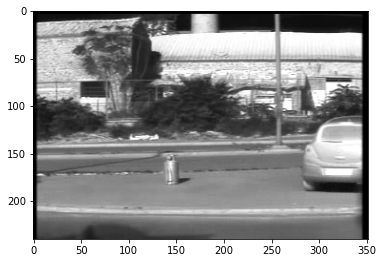

In [5]:
t = 20
plt.figure(figsize=(6,6))
plt.imshow(thermal[t], cmap='gray')
a = thermal[t]

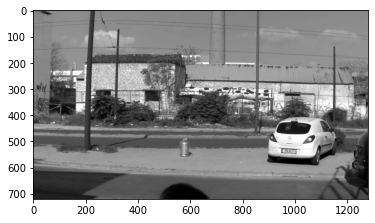

In [6]:
r = 500
plt.figure(figsize=(6,6))
plt.imshow(rgb[r], cmap='gray')
b = rgb[r]

In [7]:
# for k in range(0,500,10):
#     print(k)
#     plt.figure(figsize=(8,8))
#     plt.imshow(thermal[k], cmap='gray')

In [8]:
while True:
    sift1 = cv2.xfeatures2d.SIFT_create(nfeatures=4000)
    sift2 = cv2.xfeatures2d.SIFT_create(nfeatures=5000)
    a = thermal[t]
    b = rgb[r]
    kp1, des1  = sift1.detectAndCompute(a,None)
    kp2, des2   = sift2.detectAndCompute(b,None)
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    bf = cv2.FlannBasedMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good.append(m)

    MIN_MATCH_COUNT = 13       
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = a.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    
    if (len(good)==39):
        break

In [9]:
len(good)

39

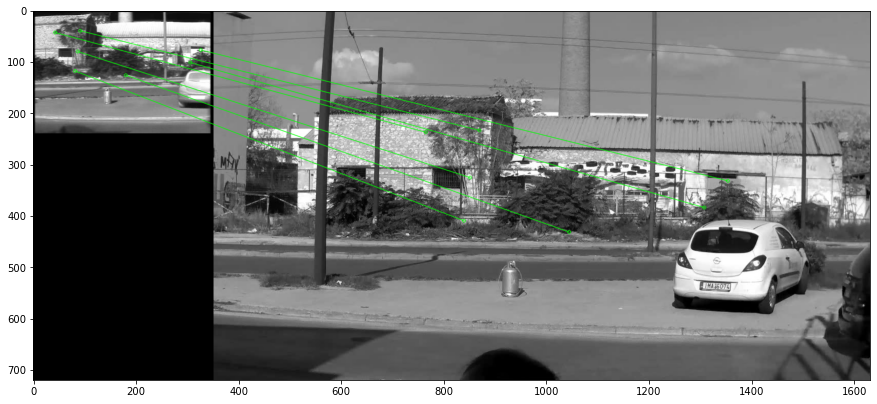

(<matplotlib.image.AxesImage at 0x2daea68e978>, None)

In [10]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(a,kp1,b,kp2,good,None,**draw_params)

plt.figure(figsize=(15,15))
plt.imshow(img3, 'gray'),plt.show()

In [12]:
list_kp1 = []
list_kp2 = []

# For each match...
for mat in good:

    # Get the matching keypoints for each of the images
    img1_idx = mat.queryIdx
    img2_idx = mat.trainIdx

    # x - columns
    # y - rows
    # Get the coordinates
    (x1,y1) = kp1[img1_idx].pt
    (x2,y2) = kp2[img2_idx].pt

    # Append to each list
    list_kp1.append((x1, y1))
    list_kp2.append((x2, y2))


def warpPerspectivePadded(img, dst, transf):

    src_h, src_w = a.shape[:2]
    lin_homg_pts = np.array([[0, src_w, src_w, 0], [0, 0, src_h, src_h], [1, 1, 1, 1]])

    trans_lin_homg_pts = transf.dot(lin_homg_pts)
    trans_lin_homg_pts /= trans_lin_homg_pts[2,:]

    minX = np.min(trans_lin_homg_pts[0,:])
    minY = np.min(trans_lin_homg_pts[1,:])
    maxX = np.max(trans_lin_homg_pts[0,:])
    maxY = np.max(trans_lin_homg_pts[1,:])

    # calculate the needed padding and create a blank image to place dst within
    dst_sz = np.asarray(list(dst.shape))
    pad_sz = dst_sz.copy() # to get the same number of channels
    pad_sz[0] = np.round(np.maximum(dst_sz[0], maxY) - np.minimum(0, minY)).astype(int)
    pad_sz[1] = np.round(np.maximum(dst_sz[1], maxX) - np.minimum(0, minX)).astype(int)
    dst_pad = np.zeros(pad_sz, dtype=np.uint8)

    # add translation to the transformation matrix to shift to positive values
    anchorX, anchorY = 0, 0
    transl_transf = np.eye(3,3)
    if minX < 0: 
        anchorX = np.round(-minX).astype(int)
        transl_transf[0,2] += anchorX
    if minY < 0:
        anchorY = np.round(-minY).astype(int)
        transl_transf[1,2] += anchorY
    new_transf = transl_transf.dot(transf)
    new_transf /= new_transf[2,2]

    dst_pad[anchorY:anchorY+dst_sz[0], anchorX:anchorX+dst_sz[1]] = dst

    warped = cv2.warpPerspective(a, new_transf, (pad_sz[1],pad_sz[0]))

    return dst_pad, warped

In [13]:
pts_src = []
pts_dst = []  

for k in range(len(matchesMask)):
    if (matchesMask[k] == 1):
        pts_src.append(list_kp1[k])
        pts_dst.append(list_kp2[k])

In [14]:
src=np.asarray(pts_src)
dst=np.asarray(pts_dst)
mi=[]
ma=[]

for i in range(2):
    mi.append(np.where(src == min(src[:,i])))
    ma.append(np.where(src == max(src[:,i])))
pts_srcf = [src[mi[0][0]][0], src[mi[1][0]][0], src[ma[0][0]][0], src[ma[1][0]][0]]

mi=[]
ma=[]

for i in range(2):
    mi.append(np.where(dst == min(dst[:,i])))
    ma.append(np.where(dst == max(dst[:,i])))
pts_dstf = [dst[mi[0][0]][0], dst[mi[1][0]][0], dst[ma[0][0]][0], dst[ma[1][0]][0]]

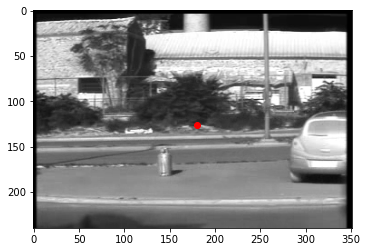

In [15]:
plt.imshow(a, cmap='gray')
plt.scatter(pts_srcf[3][0],pts_srcf[3][1],color='r')

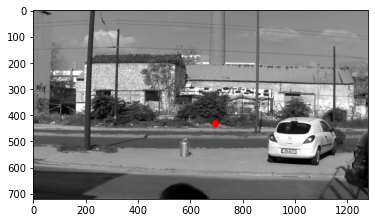

In [16]:
plt.imshow(b, cmap='gray')
plt.scatter(pts_dstf[3][0],pts_dstf[3][1],color='r')

In [17]:
pts_src = np.asarray(pts_srcf, dtype=np.float32)
pts_dst = np.asarray(pts_dstf, dtype=np.float32)  

In [18]:
# np.save('pts_src.npy',pts_src)
# np.save('pts_dst.npy',pts_dst)
# np.save('transf.npy',transf)

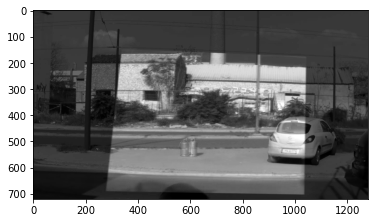

In [20]:
transf = cv2.getPerspectiveTransform(pts_src,pts_dst)
dst_pad, warped = warpPerspectivePadded(a, b, transf)

alpha = 0.6
beta = 1 - alpha
blended = cv2.addWeighted(warped, alpha, dst_pad, beta, 1.0)
plt.imshow(blended, cmap = 'gray')

In [21]:
mask=warped.copy()
for i in range(warped.shape[0]):
    for j in range(warped.shape[1]):
        if(warped[i,j]>3):
            mask[i,j]=255
nl=b.copy()
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if(mask[i,j]!=255):
            nl[i,j]=0

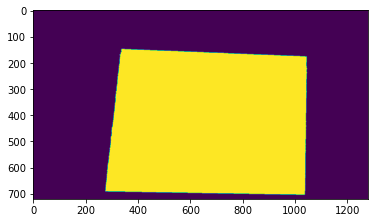

In [22]:
plt.imshow(mask)

In [23]:
_,thr = cv2.threshold(mask, 254, 255, cv2.THRESH_BINARY) 
contours= cv2.findContours(thr, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[1]
rects = [cv2.minAreaRect(cnt) for cnt in contours]
rects = sorted(rects,key=lambda  x:x[1],reverse=True)
box=[]
cnt=[]
for i in range(len(rects)):
    box.append(cv2.boxPoints(rects[i]))
    if(cv2.contourArea(box[i])>200000):
        cnt.append(box[i])

In [24]:
def rotateImage(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [25]:
import math
angle= math.atan2((cnt[0][0]-cnt[0][2])[0],(cnt[0][0]-cnt[0][2])[1])

In [26]:
rimg = rotateImage(nl, angle)

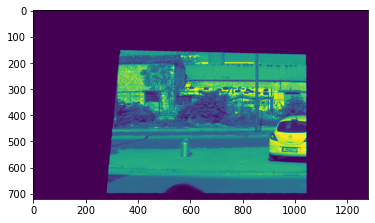

In [27]:
plt.imshow(rimg)

In [28]:
cnt=np.asarray(cnt)
cnt=cnt.reshape(4,2)

In [29]:
cl = cnt[cnt[:,1]!=min(cnt[:,1])][:,1]
cl = cl[cl!=max(cl)]
cl.sort(axis=-1)

In [30]:
rw = cnt[cnt[:,0]!=min(cnt[:,0])][:,0]
rw = rw[rw!=max(rw)]
rw.sort(axis=-1)

In [31]:
rimg = rimg[int(cl[0]):int(cl[1]),int(rw[0]):int(rw[1])]
dim = a.shape

In [32]:
rimg = cv2.resize(rimg, dim[::-1], interpolation = cv2.INTER_AREA)
a = a[10:a.shape[0]-10, 10:a.shape[1]-10]
rimg = rimg[10:rimg.shape[0]-10, 10:rimg.shape[1]-10]

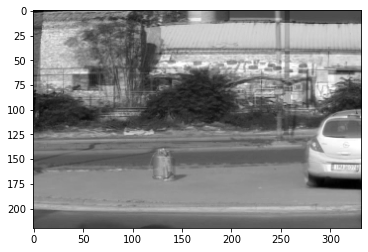

In [37]:
alpha = 0.5
beta = 1 - alpha
blended = cv2.addWeighted(a, alpha, rimg, beta, 1.0)
plt.imshow(blended, cmap='gray')

In [38]:
mask = pd.DataFrame(mask)
mask = mask.replace(2, 1)
mask = mask.replace(3, 1)
mask = mask.replace(255, 1)

In [39]:
rgbn = rgb.copy()
for k in range(rgb.shape[0]):
    rgbn[k] = mask*rgb[k]

In [40]:
del rgb

In [41]:
rimg=np.zeros(shape=rgbn.shape)
for k in range(rgbn.shape[0]):
    rimg[k] = rotateImage(rgbn[k], angle)
del rgbn

In [42]:
rgb = []
for k in range(rimg.shape[0]):
    rgb.append(rimg[k,int(cl[0]):int(cl[1]),int(rw[0]):int(rw[1])])
del rimg

In [43]:
rgbr = []
for k in range(len(rgb)):
    rgbr.append(cv2.resize(rgb[k], dim[::-1], interpolation = cv2.INTER_AREA))
del rgb

In [44]:
# rgb = []
# for k in range(len(rgbr)):
#     rgb.append(rgbr[k][10:rgbr[0].shape[0]-10, 10:rgbr[0].shape[1]-10])
# del rgbr
# rgb = np.array(rgb)

In [45]:
# thermaln = []
# for k in range(thermal.shape[0]):
#     thermaln.append(thermal[k,10:thermal.shape[1]-10, 10:thermal.shape[2]-10])
# thermal = np.array(thermaln)
# del thermaln

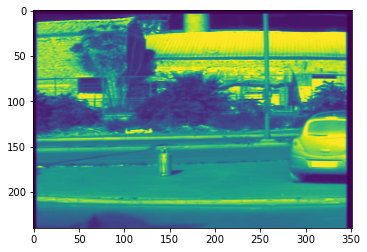

In [60]:
b = thermal[50,]
b = np.array(b).astype(int)
plt.imshow(b)

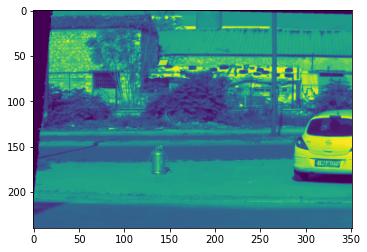

In [57]:
a = rgbr[310]
a = np.array(a).astype(int)
plt.imshow(a)

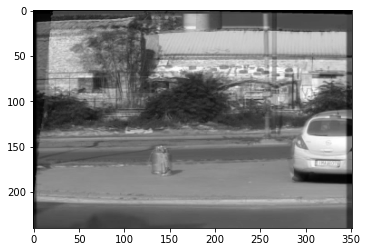

In [61]:
alpha = 0.5
beta = 1 - alpha
blended = cv2.addWeighted(a, alpha, b, beta, 1.0)
plt.imshow(blended, cmap='gray')

In [51]:
rgbr = np.array(rgbr)

In [52]:
thermal.shape

(90, 240, 352)

In [70]:
plt.imsave('rgb_background_initialization_img.png', a)
plt.imsave('thermal_background_initialization_img.png', b)

In [69]:
np.save('rgb_background_initialization_img.npy',a)
np.save('thermal_background_initialization_img.npy',b)

In [57]:
skvideo.io.vwrite("rgb_prop_cor.mp4", rgbr)

In [58]:
skvideo.io.vwrite("thermal_prop_cor.mp4", thermal)